# Make Diagnostic Plots for NA-CORDEX Zarr Stores

In [1]:
import xarray as xr
import numpy as np
import intake
import ast
import dask_jobqueue
import matplotlib.pyplot as plt

from dask_jobqueue import PBSCluster

## Create and Connect to a Dask Distributed Cluster

Run the cell below if the notebook is running on a NCAR supercomputer.
If the notebook is running on a different parallel computing environment, you will need 
to replace the usage of `PBSCluster` with a similar object from `dask_jobqueue` or `dask_gateway`.

In [2]:
num_jobs = 20
walltime = '0:20:00'
memory='10GB' 

cluster = PBSCluster(cores=1, processes=1, walltime=walltime, memory=memory, queue='casper', 
                     resource_spec='select=1:ncpus=1:mem=10GB',)
cluster.scale(jobs=num_jobs)


from distributed import Client
client = Client(cluster)
cluster

PBSCluster(3c98ff67, 'tcp://10.12.206.46:36255', workers=0, threads=0, memory=0 B)

☝️ Link to Dask dashboard will appear above.

## Find and Obtain Data Using an Intake Catalog

#### Choose Cloud Storage (AWS or NCAR Cloud)

In [3]:
# If True,  use NCAR Cloud Storage.  Requires an NCAR user account. 
# If False, use AWS  Cloud Storage.

USE_NCAR_CLOUD_STORAGE = False

#### Define the Intake Catalog URL and Storage Access Options

In [4]:
if USE_NCAR_CLOUD_STORAGE:
    catalog_url = "https://stratus.ucar.edu/ncar-na-cordex/catalogs/aws-na-cordex.json"
    storage_options={"anon": True, 'client_kwargs':{"endpoint_url":"https://stratus.ucar.edu/"}}
                     
else:
    catalog_url = "https://ncar-na-cordex.s3-us-west-2.amazonaws.com/catalogs/aws-na-cordex.json"
    storage_options={"anon": True}

#### Open catalog and produce a content summary

In [5]:
# Have the catalog interpret the "na-cordex-models" column as a list of values, as opposed to single values.
col = intake.open_esm_datastore(catalog_url, read_csv_kwargs={"converters": {"na-cordex-models": ast.literal_eval}},)
col

In [6]:
# Show the first few lines of the catalog
col.df.head(10)

variable      standard_name                       long_name units   
0     hurs  relative_humidity  Near-Surface Relative Humidity     %  \
1     hurs  relative_humidity  Near-Surface Relative Humidity     %   
2     hurs  relative_humidity  Near-Surface Relative Humidity     %   
3     hurs  relative_humidity  Near-Surface Relative Humidity     %   
4     hurs  relative_humidity  Near-Surface Relative Humidity     %   
5     hurs  relative_humidity  Near-Surface Relative Humidity     %   
6     hurs  relative_humidity  Near-Surface Relative Humidity     %   
7     hurs  relative_humidity  Near-Surface Relative Humidity     %   
8     hurs  relative_humidity  Near-Surface Relative Humidity     %   
9     hurs  relative_humidity  Near-Surface Relative Humidity     %   

  spatial_domain     grid spatial_resolution    scenario           start_time   
0  north_america  NAM-22i           0.25 deg        eval  1979-01-01T12:00:00  \
1  north_america  NAM-44i           0.50 deg        eval  1979-01-01T12:00:00   
2  north_america  NAM-22i           0.25 deg  hist-rcp45  1949-01-01T12:00:00   
3  north_america  NAM-22i           0.25 deg  hist-rcp45  1949-01-01T12:00:00   
4  north_america  NAM-22i           0.25 deg  hist-rcp45  1949-01-01T12:00:00   
5  north_america  NAM-44i           0.50 deg  hist-rcp45  1949-01-01T12:00:00   
6  north_america  NAM-44i           0.50 deg  hist-rcp45  1949-01-01T12:00:00   
7  north_america  NAM-44i           0.50 deg  hist-rcp45  1949-01-01T12:00:00   
8  north_america  NAM-22i           0.25 deg  hist-rcp85  1949-01-01T12:00:00   
9  north_america  NAM-22i           0.25 deg  hist-rcp85  1949-01-01T12:00:00   

              end_time frequency  vertical_levels bias_correction   
0  2014-12-31T12:00:00       day                1             raw  \
1  2015-12-31T12:00:00       day                1             raw   
2  2100-12-31T12:00:00       day                1     mbcn-Daymet   
3  2100-12-31T12:00:00       day                1    mbcn-gridMET   
4  2100-12-31T12:00:00       day                1             raw   
5  2100-12-31T12:00:00       day                1     mbcn-Daymet   
6  2100-12-31T12:00:00       day                1    mbcn-gridMET   
7  2100-12-31T12:00:00       day                1             raw   
8  2100-12-31T12:00:00       day                1     mbcn-Daymet   
9  2100-12-31T12:00:00       day                1    mbcn-gridMET   

                                    na-cordex-models   
0  [ERA-Int.CRCM5-UQAM, ERA-Int.CRCM5-OUR, ERA-In...  \
1  [ERA-Int.CRCM5-UQAM, ERA-Int.RegCM4, ERA-Int.H...   
2                                  [CanESM2.CanRCM4]   
3                                  [CanESM2.CanRCM4]   
4  [GFDL-ESM2M.CRCM5-OUR, CanESM2.CRCM5-OUR, CanE...   
5  [MPI-ESM-LR.CRCM5-UQAM, CanESM2.CRCM5-UQAM, EC...   
6  [MPI-ESM-LR.CRCM5-UQAM, CanESM2.CRCM5-UQAM, EC...   
7  [MPI-ESM-LR.CRCM5-UQAM, CanESM2.CRCM5-UQAM, EC...   
8  [MPI-ESM-MR.CRCM5-UQAM, GEMatm-Can.CRCM5-UQAM,...   
9  [MPI-ESM-MR.CRCM5-UQAM, GEMatm-Can.CRCM5-UQAM,...   

                                                path  
0  s3://ncar-na-cordex/day/hurs.eval.day.NAM-22i....  
1  s3://ncar-na-cordex/day/hurs.eval.day.NAM-44i....  
2  s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...  
3  s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...  
4  s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...  
5  s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...  
6  s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...  
7  s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...  
8  s3://ncar-na-cordex/day/hurs.hist-rcp85.day.NA...  
9  s3://ncar-na-cordex/day/hurs.hist-rcp85.day.NA...

In [7]:
# Produce a catalog content summary.

uniques = col.unique()

columns = ["variable", "scenario", "grid", "na-cordex-models", "bias_correction"]
for column in columns:
    print(f'{column}: {uniques[column]}\n')

variable: ['hurs', 'huss', 'pr', 'prec', 'ps', 'rsds', 'sfcWind', 'tas', 'tasmax', 'tasmin', 'temp', 'tmax', 'tmin', 'uas', 'vas']

scenario: ['eval', 'hist-rcp45', 'hist-rcp85', 'hist', 'rcp45', 'rcp85']

grid: ['NAM-22i', 'NAM-44i']

na-cordex-models: ['ERA-Int.CRCM5-UQAM', 'ERA-Int.CRCM5-OUR', 'ERA-Int.RegCM4', 'ERA-Int.CanRCM4', 'ERA-Int.WRF', 'ERA-Int.HIRHAM5', 'ERA-Int.RCA4', 'CanESM2.CanRCM4', 'GFDL-ESM2M.CRCM5-OUR', 'CanESM2.CRCM5-OUR', 'MPI-ESM-LR.CRCM5-UQAM', 'CanESM2.CRCM5-UQAM', 'EC-EARTH.HIRHAM5', 'EC-EARTH.RCA4', 'CanESM2.RCA4', 'MPI-ESM-MR.CRCM5-UQAM', 'GEMatm-Can.CRCM5-UQAM', 'GEMatm-MPI.CRCM5-UQAM', 'HadGEM2-ES.RegCM4', 'GFDL-ESM2M.RegCM4', 'MPI-ESM-LR.RegCM4', 'HadGEM2-ES.WRF', 'GFDL-ESM2M.WRF', 'MPI-ESM-LR.WRF', 'CNRM-CM5.CRCM5-OUR', 'MPI-ESM-LR.CRCM5-OUR']

bias_correction: ['raw', 'mbcn-Daymet', 'mbcn-gridMET']



#### Load data into xarray using the catalog

In [8]:
data_var = 'tmax'

col_subset = col.search(
    variable=data_var,
    grid="NAM-44i",
    scenario="eval",
    bias_correction="raw",
)

col_subset

In [9]:
col_subset.df

variable    standard_name                                   long_name units   
0     tmax  air_temperature  Daily Maximum Near-Surface Air Temperature  degC  \

  spatial_domain     grid spatial_resolution scenario           start_time   
0  north_america  NAM-44i           0.50 deg     eval  1979-01-01T12:00:00  \

              end_time frequency  vertical_levels bias_correction   
0  2015-12-31T12:00:00       day                1             raw  \

                                    na-cordex-models   
0  [ERA-Int.CRCM5-UQAM, ERA-Int.RegCM4, ERA-Int.H...  \

                                                path  
0  s3://ncar-na-cordex/day/tmax.eval.day.NAM-44i....

In [10]:
# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.
dsets = col_subset.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True}, storage_options=storage_options
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")

# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
store_name = dataset_key + ".zarr"

ds = dsets[dataset_key]
ds

# Note that the summary includes a 'member_id' coordinate, which is a renaming of the 
# 'na-cordex-models' column in the catalog.


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.scenario.grid.bias_correction'



Dataset dictionary keys:
 dict_keys(['tmax.day.eval.NAM-44i.raw'])


<xarray.Dataset>
Dimensions:    (lat: 129, lon: 300, member_id: 6, time: 13514, bnds: 2)
Coordinates:
  * lat        (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon        (lon) float64 -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
  * member_id  (member_id) <U18 'ERA-Int.CRCM5-UQAM' ... 'ERA-Int.WRF'
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2015-12-31T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(13514, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tmax       (member_id, time, lat, lon) float32 dask.array<chunksize=(4, 1000, 65, 150), meta=np.ndarray>
Attributes: (12/42)
    CORDEX_domain:                        NAM-44
    contact:                              {"ERA-Int.CRCM5-UQAM": "Winger.Katj...
    contact_note:                         {"ERA-Int.RegCM4": "Simulations by ...
    creation_date:                        {"ERA-Int.CRCM5-UQAM": "2015-06-18T...
    driving_experiment:                   {"ERA-Int.CRCM5-UQAM": "ECMWF-ERAIN...
    driving_experiment_name:              evaluation
    ...                                   ...
    intake_esm_attrs:vertical_levels:     1
    intake_esm_attrs:bias_correction:     raw
    intake_esm_attrs:na-cordex-models:    ERA-Int.CRCM5-UQAM,ERA-Int.RegCM4,E...
    intake_esm_attrs:path:                s3://ncar-na-cordex/day/tmax.eval.d...
    intake_esm_attrs:_data_format_:       zarr
    intake_esm_dataset_key:               tmax.day.eval.NAM-44i.raw

## Functions for Plotting

#### Helper Function to Create a Single Map Plot

In [11]:
def plotMap(ax, map_slice, date_object=None, member_id=None):
    """Create a map plot on the given axes, with min/max as text"""

    ax.imshow(map_slice, origin='lower')

    minval = map_slice.min(dim = ['lat', 'lon'])
    maxval = map_slice.max(dim = ['lat', 'lon'])

    # Format values to have at least 4 digits of precision.
    ax.text(0.01, 0.03, "Min: %3g" % minval, transform=ax.transAxes, fontsize=12)
    ax.text(0.99, 0.03, "Max: %3g" % maxval, transform=ax.transAxes, fontsize=12, horizontalalignment='right')
    ax.set_xticks([])
    ax.set_yticks([])
    
    if date_object:
        ax.set_title(date_object.values.astype(str)[:10], fontsize=12)
        
    if member_id:
        ax.set_ylabel(member_id, fontsize=12)
        
    return ax

#### Helper Function for Finding Dates with Available Data

In [12]:
def getValidDateIndexes(member_slice):
    """Search for the first and last dates with finite values."""
    min_values = member_slice.min(dim = ['lat', 'lon'])
    is_finite = np.isfinite(min_values)
    finite_indexes = np.where(is_finite)

    start_index = finite_indexes[0][0]
    end_index = finite_indexes[0][-1]
    return start_index, end_index

#### Function Producing Maps of First, Middle, and Final Timesteps

In [13]:
def plot_first_mid_last(ds, data_var, store_name):
    """Plot the first, middle, and final time steps for several climate runs."""
    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]
    
    figWidth = 18 
    figHeight = 12 
    numPlotColumns = 3
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight), constrained_layout=True)

    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)
           
        start_index, end_index = getValidDateIndexes(data_slice)
        midDateIndex = np.floor(len(ds.time) / 2).astype(int)

        startDate = ds.time[start_index]
        first_step = data_slice.sel(time=startDate) 
        ax = axs[index, 0]
        plotMap(ax, first_step, startDate, mem_id)

        midDate = ds.time[midDateIndex]
        mid_step = data_slice.sel(time=midDate)   
        ax = axs[index, 1]
        plotMap(ax, mid_step, midDate)

        endDate = ds.time[end_index]
        last_step = data_slice.sel(time=endDate)            
        ax = axs[index, 2]
        plotMap(ax, last_step, endDate)
        
        plt.suptitle(f'First, Middle, and Last Timesteps for Selected Runs in "{store_name}"', fontsize=20)

    return fig

#### Function Producing Statistical Map Plots

In [14]:
def plot_stat_maps(ds, data_var, store_name):
    """Plot the mean, min, max, and standard deviation values for several climate runs, aggregated over time."""
    
    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]

    figWidth = 25 
    figHeight = 12 
    numPlotColumns = 4
    
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight), constrained_layout=True)

    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)

        # Save slice in memory to prevent repeated disk loads
        data_slice = data_slice.persist()

        data_agg = data_slice.min(dim='time')
        plotMap(axs[index, 0], data_agg, member_id=mem_id)

        data_agg = data_slice.max(dim='time')
        plotMap(axs[index, 1], data_agg)

        data_agg = data_slice.mean(dim='time')
        plotMap(axs[index, 2], data_agg)

        data_agg = data_slice.std(dim='time')
        plotMap(axs[index, 3], data_agg)

    axs[0, 0].set_title(f'min({data_var})', fontsize=15)
    axs[0, 1].set_title(f'max({data_var})', fontsize=15)
    axs[0, 2].set_title(f'mean({data_var})', fontsize=15)
    axs[0, 3].set_title(f'std({data_var})', fontsize=15)

    plt.suptitle(f'Spatial Statistics for Selected Runs in "{store_name}"', fontsize=20)

    return fig

#### Function Producing Time Series Plots
Also show which dates have no available data values, as a rug plot.

In [15]:
def plot_timeseries(ds, data_var, store_name):
    """Plot the mean, min, max, and standard deviation values for several climate runs, 
       aggregated over lat/lon dimensions."""

    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]

    figWidth = 25 
    figHeight = 20
    linewidth = 0.5

    numPlotColumns = 1
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight))
        
    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)
        unit_string = ds[data_var].attrs['units']
        
        # Save slice in memory to prevent repeated disk loads
        data_slice = data_slice.persist()

        min_vals = data_slice.min(dim = ['lat', 'lon'])
        max_vals = data_slice.max(dim = ['lat', 'lon'])
        mean_vals = data_slice.mean(dim = ['lat', 'lon'])
        std_vals = data_slice.std(dim = ['lat', 'lon'])

        #missing_indexes = np.isnan(min_vals)
        missing_indexes = np.isnan(min_vals).compute()
        missing_times = ds.time[missing_indexes]

            
        axs[index].plot(ds.time, max_vals, linewidth=linewidth, label='max', color='red')
        axs[index].plot(ds.time, mean_vals, linewidth=linewidth, label='mean', color='black')
        axs[index].fill_between(ds.time, (mean_vals - std_vals), (mean_vals + std_vals), 
                                         color='grey', linewidth=0, label='std', alpha=0.5)
        axs[index].plot(ds.time, min_vals, linewidth=linewidth, label='min', color='blue')
            
        ymin, ymax = axs[index].get_ylim()
        rug_y = ymin + 0.01*(ymax-ymin)
        axs[index].plot(missing_times, [rug_y]*len(missing_times), '|', color='m', label='missing')
        axs[index].set_title(mem_id, fontsize=20)
        axs[index].legend(loc='upper right')
        axs[index].set_ylabel(unit_string)

    plt.tight_layout(pad=10.2, w_pad=3.5, h_pad=3.5)
    plt.suptitle(f'Temporal Statistics for Selected Runs in "{store_name}"', fontsize=20)

    return fig

## Produce Diagnostic Plots

### Plot First, Middle, and Final Timesteps for Several Output Runs (less compute intensive)

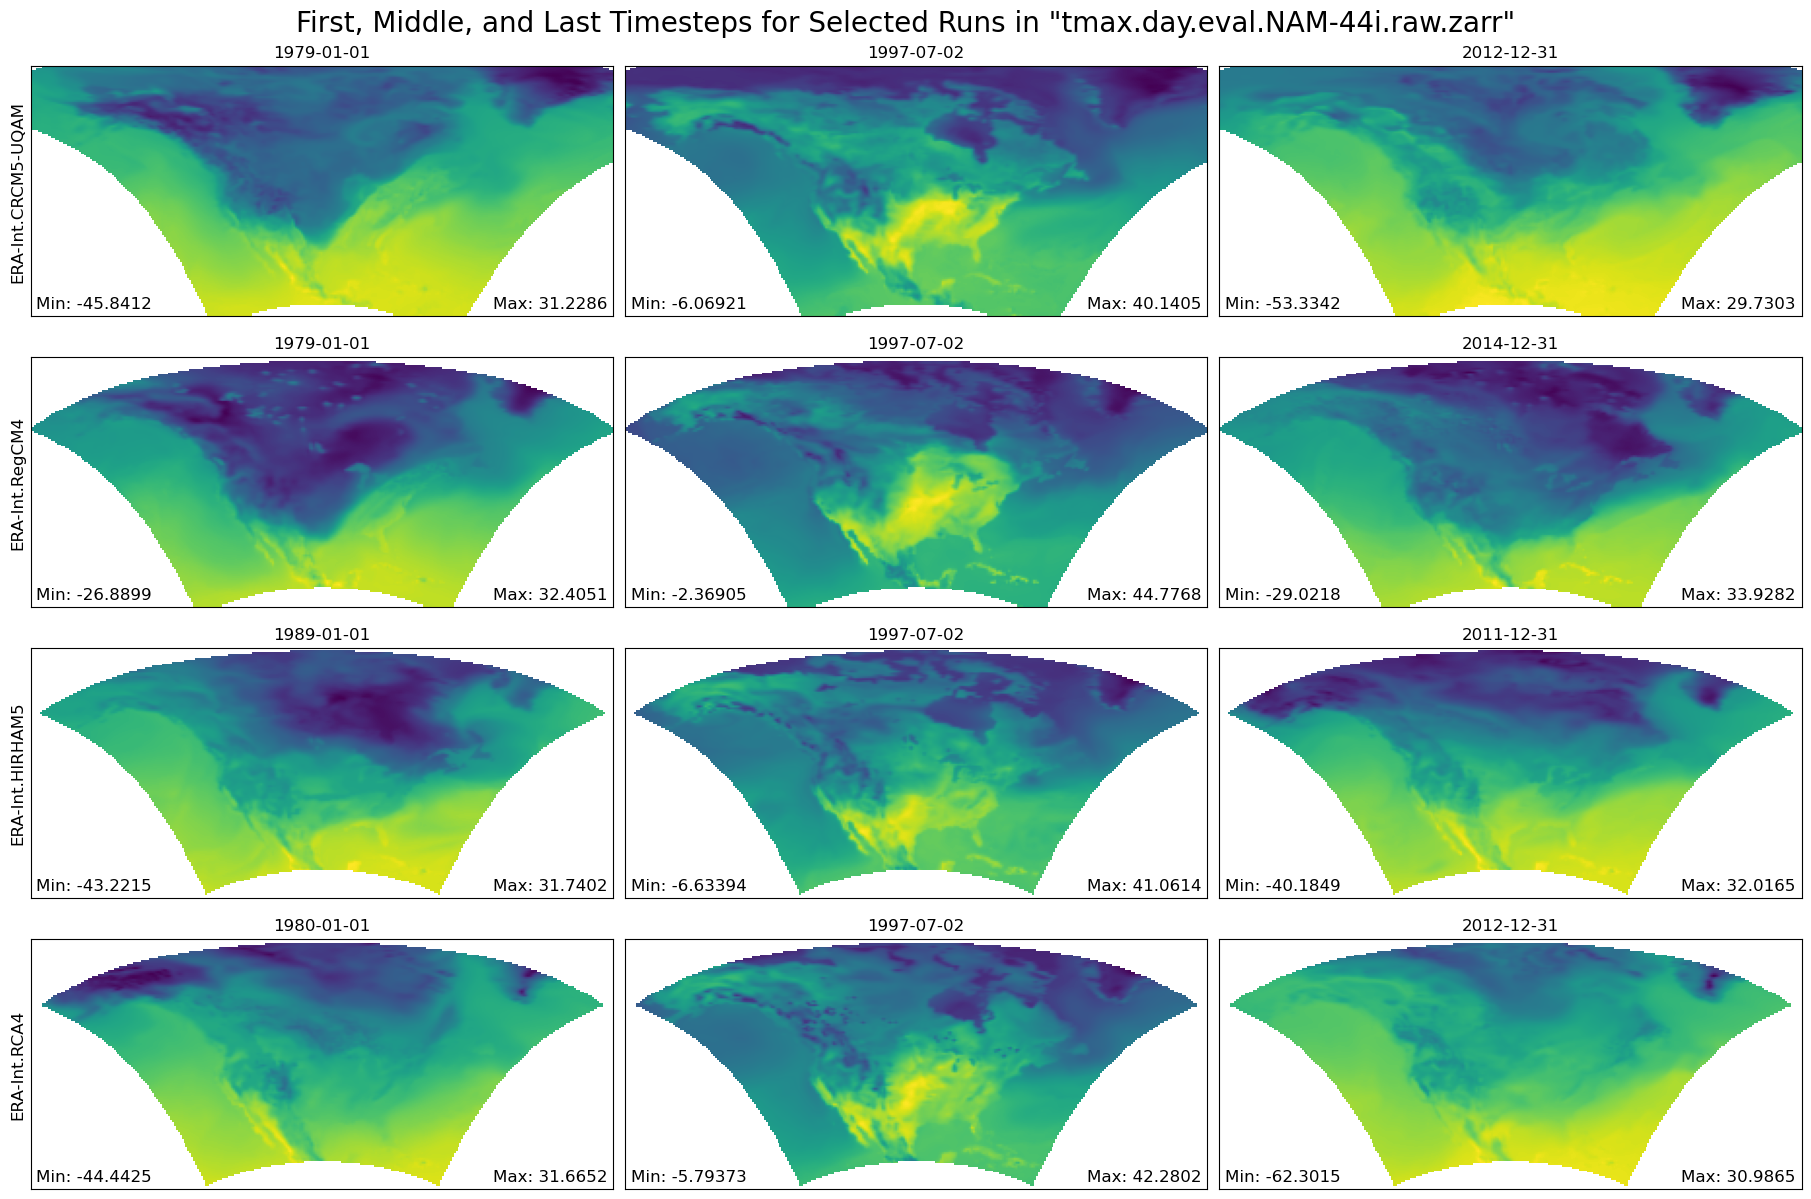

CPU times: user 3.86 s, sys: 276 ms, total: 4.13 s
Wall time: 1min 16s


In [16]:
%%time

# Plot using the Zarr Store obtained from an earlier step in the notebook.
figure = plot_first_mid_last(ds, data_var, store_name)

plt.show()

#### Optional: save figure to a PNG file

Change the value of SAVE_PLOT to True to produce a PNG file of the plot.   The file will be saved in the same folder as this notebook.

Then use Jupyter's file browser to locate the file and right-click the file to download it.   

In [17]:
SAVE_PLOT = False
if SAVE_PLOT:
    plotfile = f'./{dataset_key}_FML.png'
    figure.savefig(plotfile, dpi=100)

### Create Statistical Map Plots for Several Output Runs (more compute intensive)

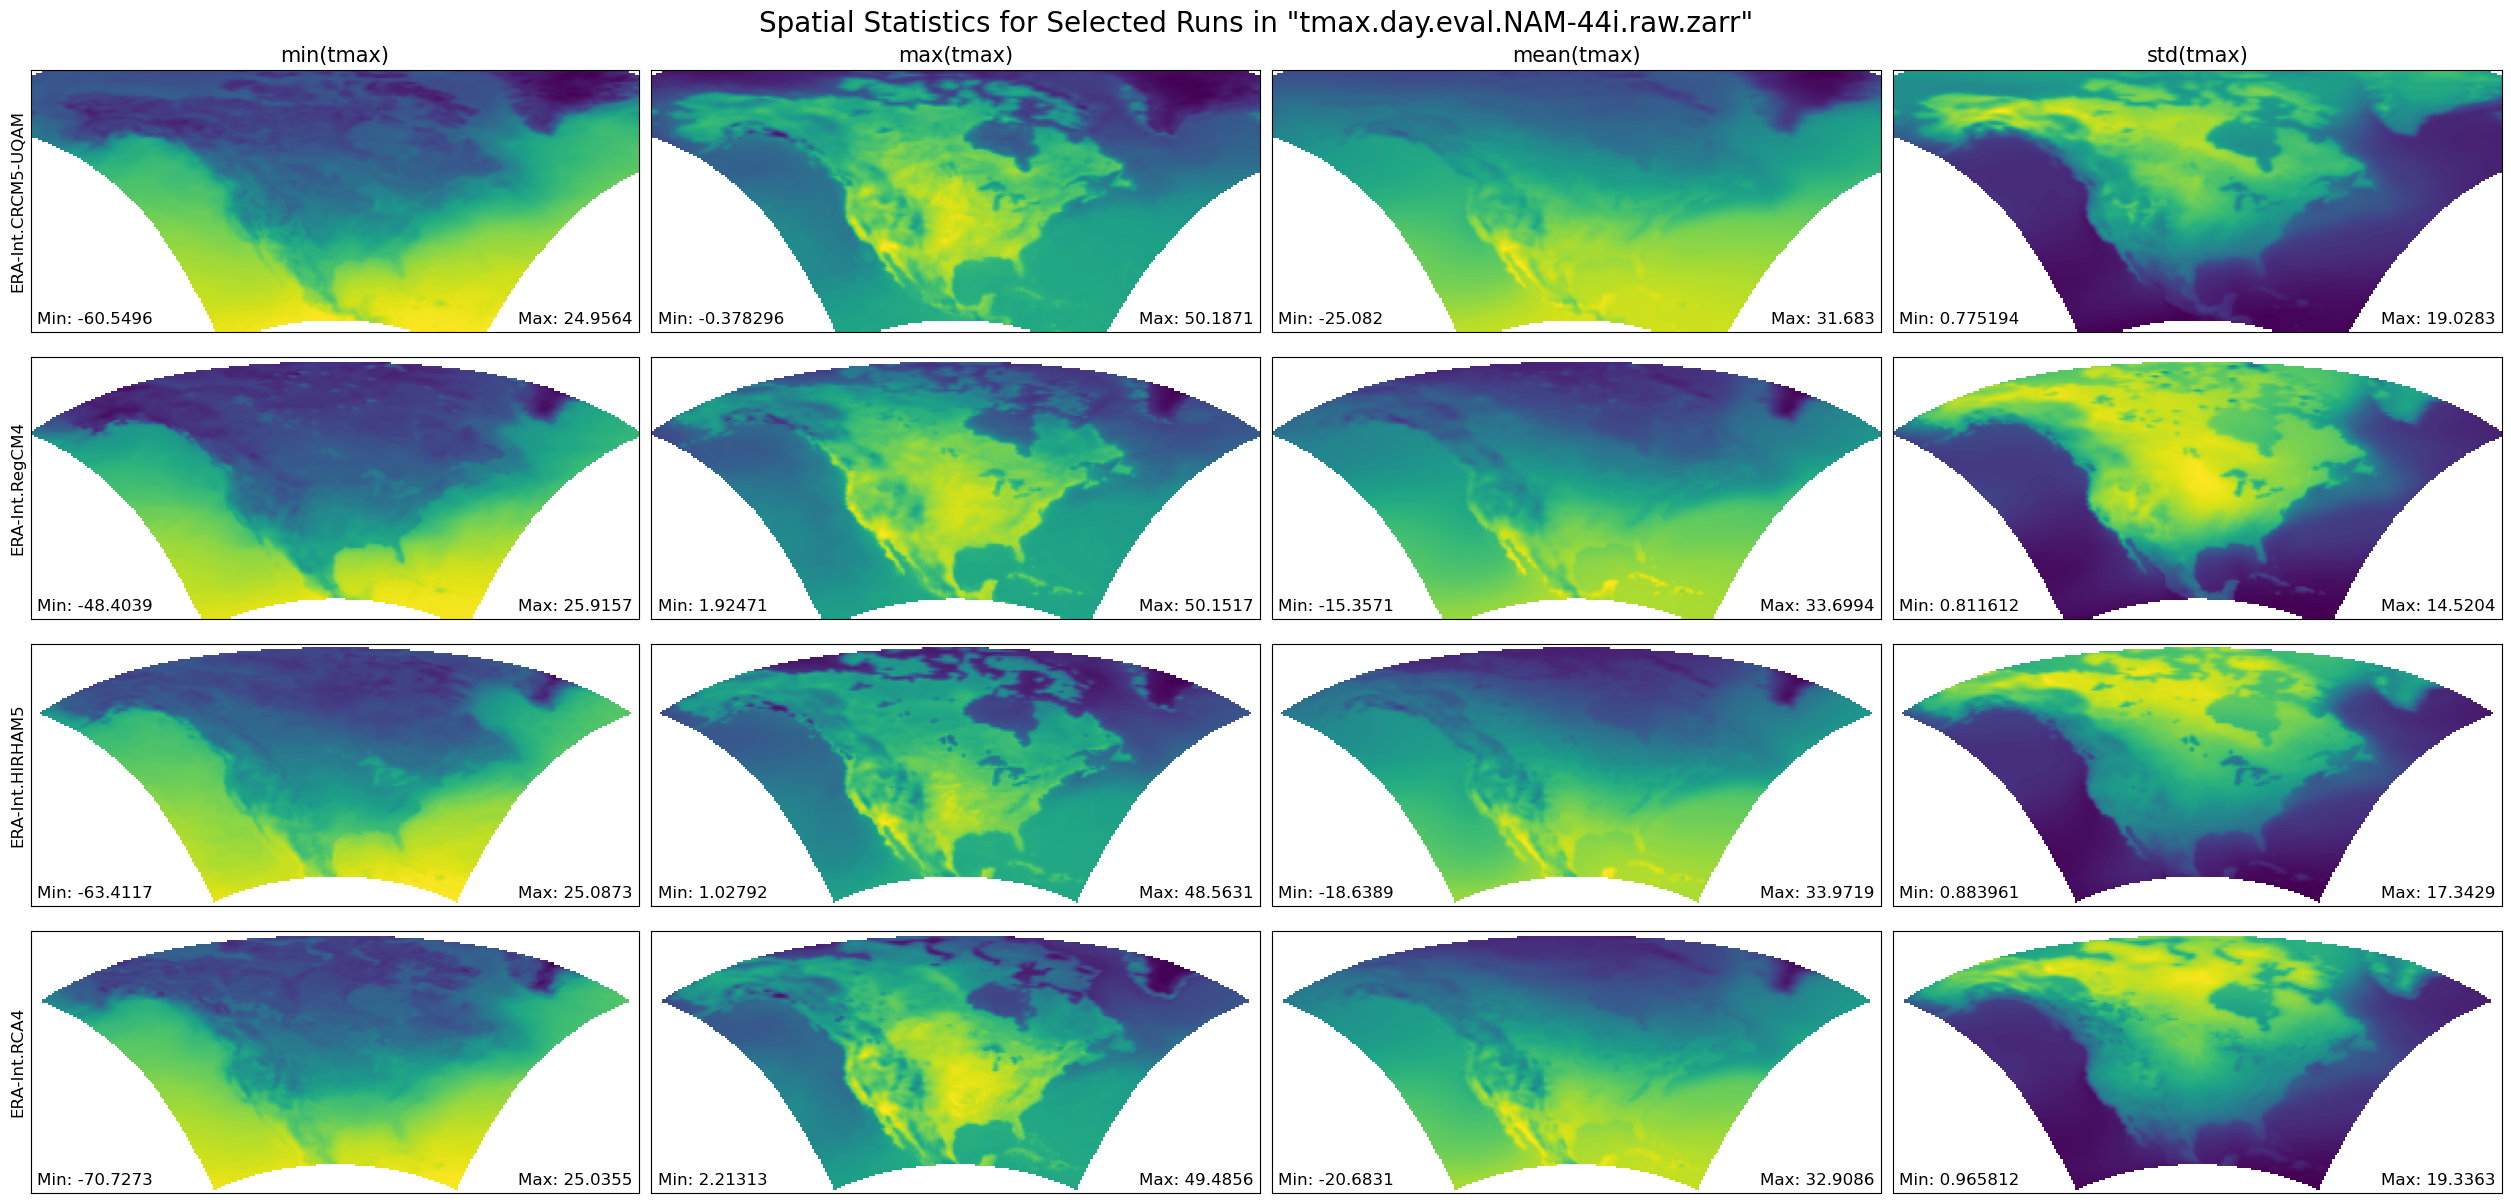

CPU times: user 6.11 s, sys: 371 ms, total: 6.49 s
Wall time: 1min 22s


In [18]:
%%time

# Plot using the Zarr Store obtained from an earlier step in the notebook.
figure = plot_stat_maps(ds, data_var, store_name)

plt.show()

#### Optional: save figure to a PNG file

Change the value of SAVE_PLOT to True to produce a PNG file of the plot.   The file will be saved in the same folder as this notebook.

Then use Jupyter's file browser to locate the file and right-click the file to download it.   

In [19]:
SAVE_PLOT = False
if SAVE_PLOT:
    plotfile = f'./{dataset_key}_MAPS.png'
    figure.savefig(plotfile, dpi=100)

### Plot Time Series for Several Output Runs (more compute intensive)

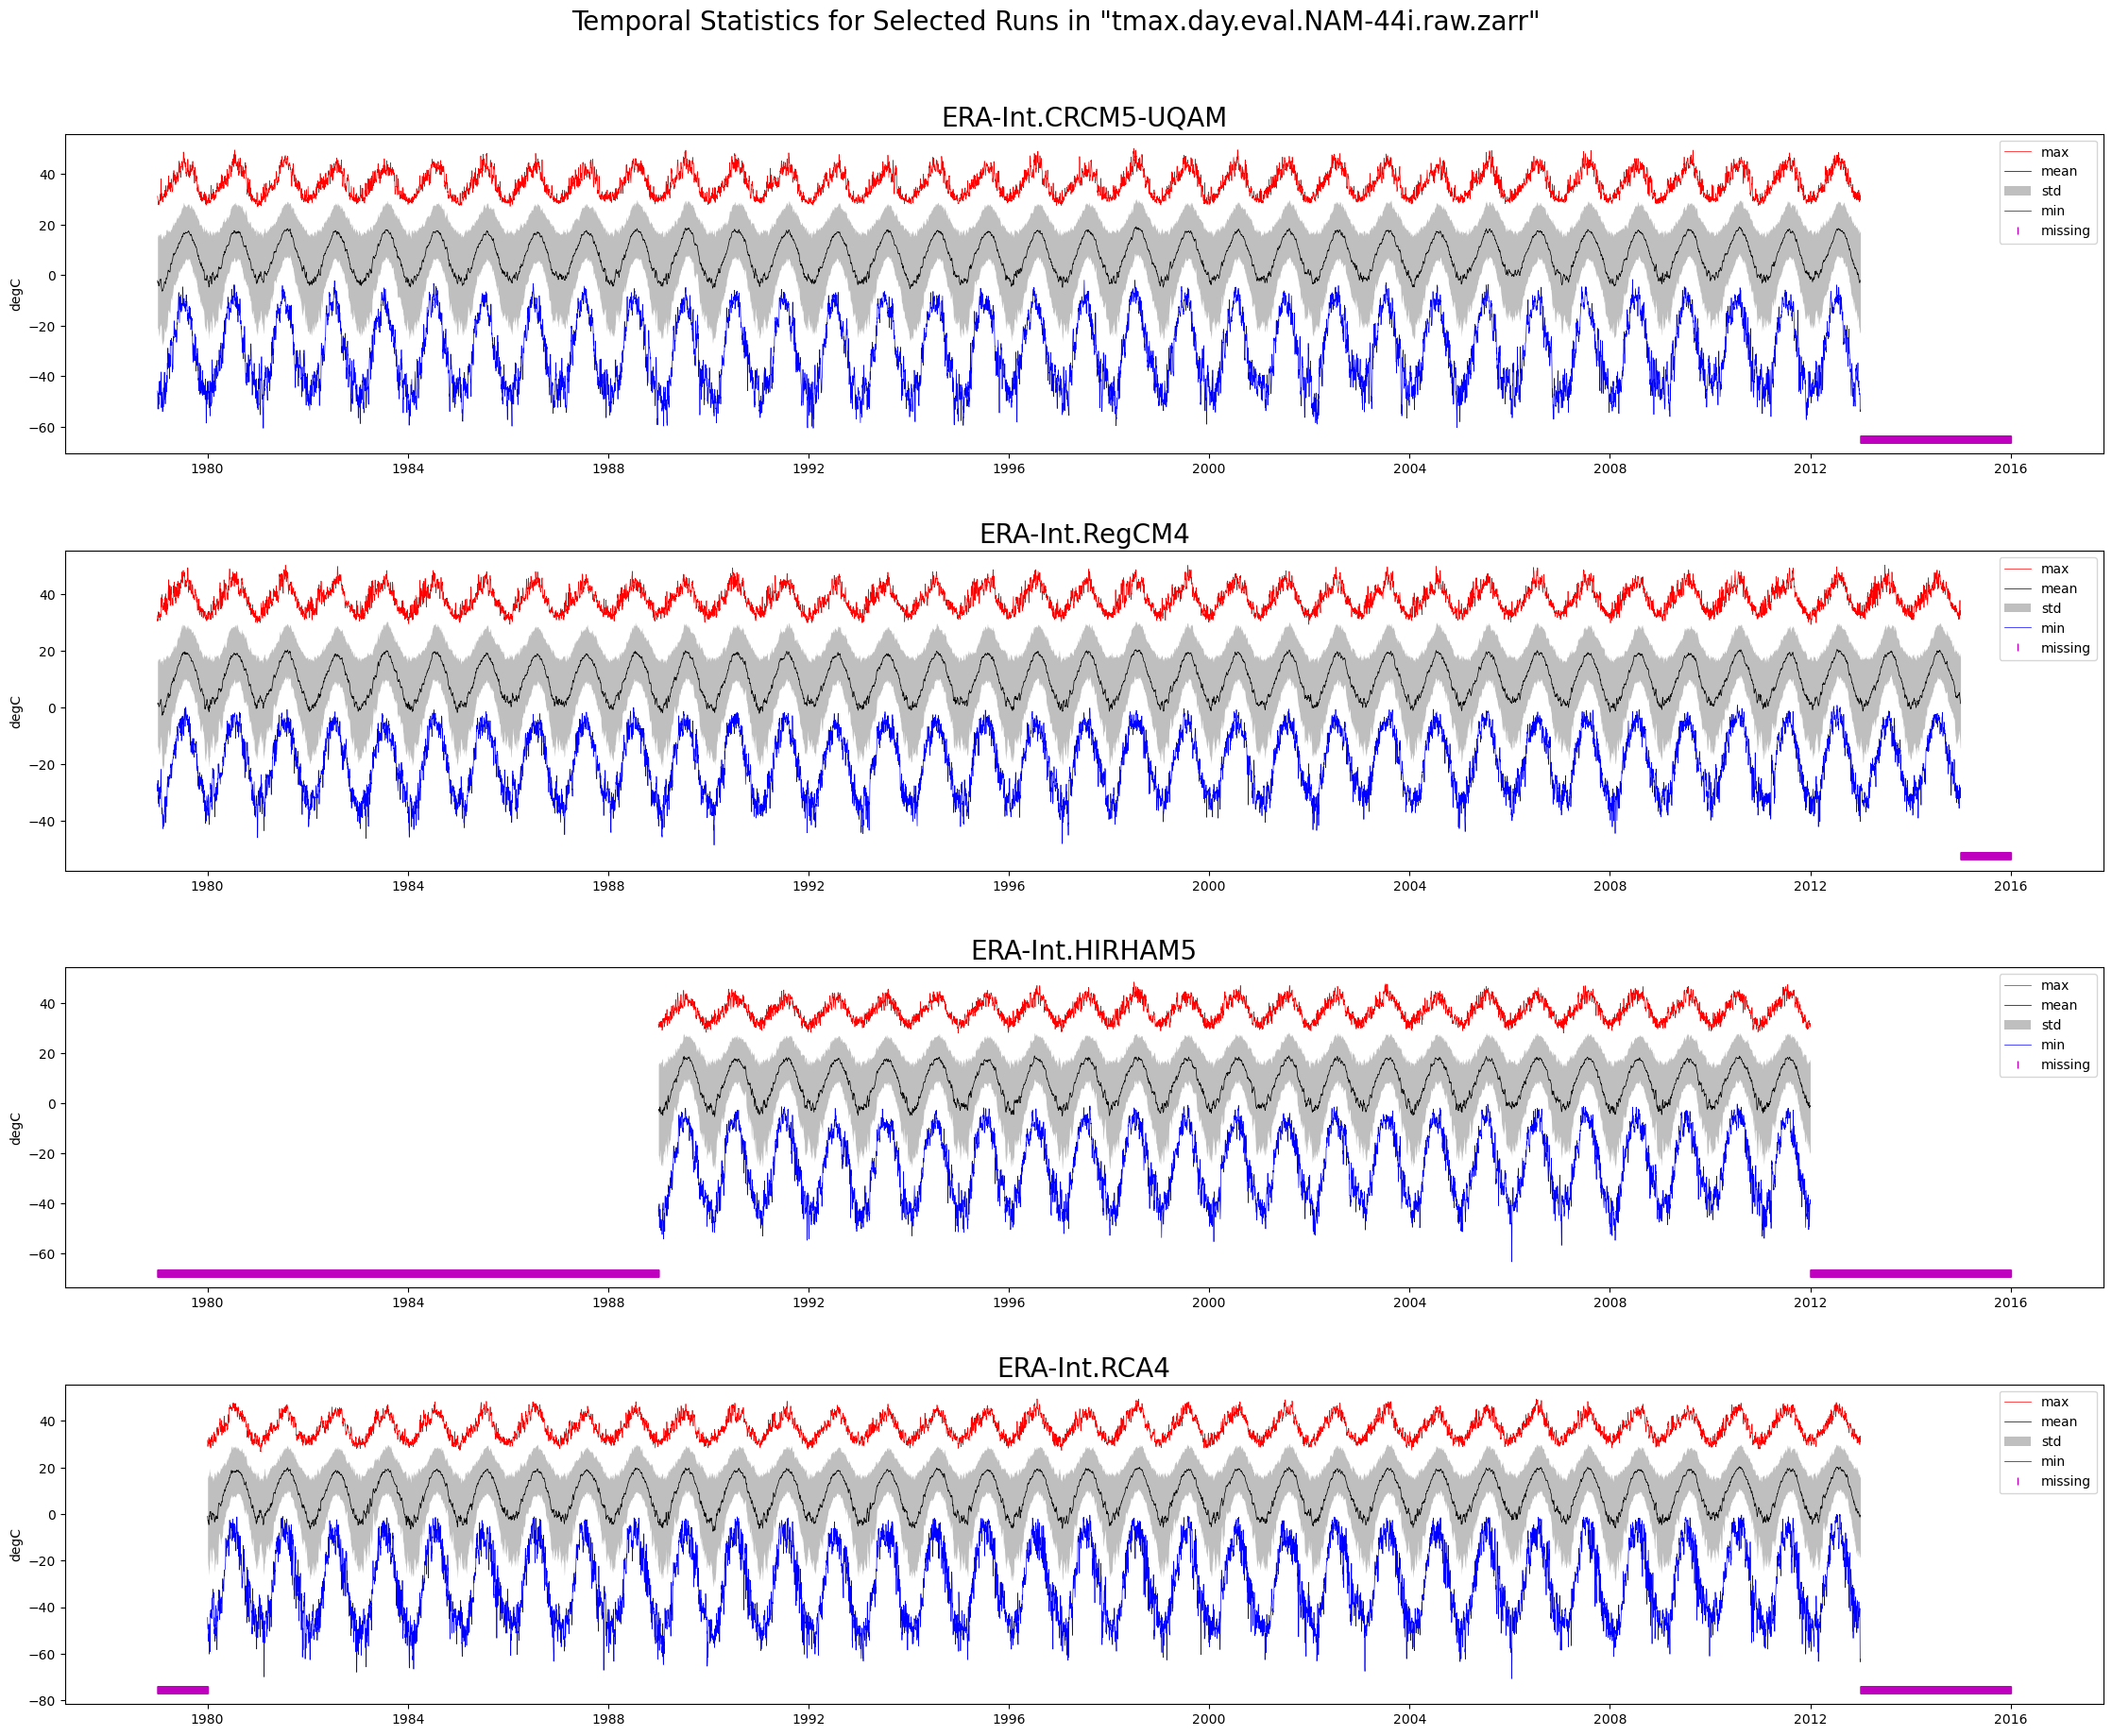

CPU times: user 8.06 s, sys: 654 ms, total: 8.72 s
Wall time: 1min 55s


In [20]:
%%time

# Plot using the Zarr Store obtained from an earlier step in the notebook.
figure = plot_timeseries(ds, data_var, store_name)

plt.show()

#### Optional: save figure to a PNG file

Change the value of SAVE_PLOT to True to produce a PNG file of the plot.   The file will be saved in the same folder as this notebook.

Then use Jupyter's file browser to locate the file and right-click the file to download it.   

In [21]:
SAVE_PLOT = False
if SAVE_PLOT:
    plotfile = f'./{dataset_key}_TS.png'
    figure.savefig(plotfile, dpi=100)

### Release the workers

In [22]:
!date

Thu May 18 11:37:29 MDT 2023


In [ ]:
cluster.close()

### Show which python package versions were used

In [24]:
%load_ext watermark
%watermark -iv

intake       : 0.6.8
json         : 2.0.9
sys          : 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:57:19) [GCC 11.3.0]
dask_jobqueue: 0.8.1
matplotlib   : 3.7.1
xarray       : 2023.4.2
numpy        : 1.24.3

